In [ ]:
import tensorflow
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split


In [ ]:
import keras
keras.__version__

'3.4.1'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# Reading Images from data set test and train

df = pd.read_csv(r"/content/train_dataset.csv")
def pixels_to_image(pixel_str):
    # Assuming each image is 48x48 pixels
    pixels = np.array([int(p) for p in pixel_str.split()], dtype='uint8')
    # print(len(pixels))
    img = pixels.reshape(48, 48)  # Adjust if image dimensions are different
    img = cv2.resize(img, (48, 48))
    img = cv2.GaussianBlur(img,(3,3),0)

    return img

# Add a column with images
df['image'] = df['pixels'].apply(pixels_to_image)

# Display the first few rows with images and emotion
# for idx, row in df.iterrows():
    # plt.figure()
    # plt.imshow(row['image'], cmap='gray')
    # plt.title(f"Emotion: {row['emotion']}")
    # plt.show()


In [ ]:
# Implies the data is 224*224 and 5000 images

print(df['image'][0])
len(df['image'][0])

[[ 69  70  69 ...  53  48  45]
 [ 62  62  62 ...  52  50  47]
 [ 49  51  56 ...  48  50  49]
 ...
 [ 73  65  52 ...  78  62  55]
 [ 78  76  71 ...  92  76  65]
 [ 77  78  80 ... 100  87  77]]


48

In [ ]:
X_train = df['image']

In [ ]:
y_train = df['emotion']

In [ ]:
emo_meta = [0,0,0,0,0,0,0]

for i in y_train:
    emo_meta[i] += 1
print(emo_meta)


# Original data set [714, 72, 726, 1278, 817, 525, 868]
# y_train [643, 65, 653, 1150, 735, 473, 781]
# y_test [71, 7, 73, 128, 82, 52, 87]

[714, 72, 726, 1278, 817, 525, 868]


In [ ]:


X_train_flattened = np.array(X_train.tolist())
num_images = X_train_flattened.shape[0]
X_train = X_train_flattened.reshape((num_images, 48, 48, 1))

X_train.shape

(5000, 48, 48, 1)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
from sklearn.model_selection import train_test_split

# Optional: Normalize images if required
# X_train = X_train.astype(np.float32) / 255.0

# Define augmentation generator
datagen = ImageDataGenerator(
    horizontal_flip=True,               # Horizontal Flip
    rotation_range=20,                  # Random Rotation
    width_shift_range=0.2,              # Random Shift
    height_shift_range=0.2,             # Random Shift
    brightness_range=[0.7, 1.3],        # Random Brightness Contrast
    zoom_range=0.2,                     # Zoom
    fill_mode='nearest'                 # Fill mode for newly created pixels
)

# Define target number of images based on the class with the most images (class 3)
target_images_per_class = 900

# Prepare lists for augmented data
augmented_X_train = []
augmented_y_train = []

# Augment images for each class
for class_label in np.unique(y_train):
    # Get all images of the current class
    X_class = X_train[y_train == class_label]
    current_num_images = X_class.shape[0]

    # Calculate how many images to augment
    num_to_augment = target_images_per_class - current_num_images

    if num_to_augment > 0:
        num_per_image = int(num_to_augment // current_num_images) + 1
        print(num_per_image)

        # Apply augmentation to the class
        for image in X_class:
            image = image[np.newaxis, ...]  # Add batch dimension
            image_gen = datagen.flow(image, batch_size=1)  # Use batch_size=1

            # Generate images for this particular image
            for _ in range(num_per_image):
                augmented_image = next(image_gen)[0]  # Get the augmented image
                augmented_X_train.append(augmented_image)
                augmented_y_train.append(class_label)

                if len(augmented_X_train) >= num_to_augment:
                    break
            if len(augmented_X_train) >= num_to_augment:
                break

# Convert lists to NumPy arrays
if augmented_X_train:
    augmented_X_train = np.array(augmented_X_train, dtype=np.uint8)
    augmented_y_train = np.array(augmented_y_train, dtype=np.int32)
    print(f"Augmented X_train shape: {augmented_X_train.shape}")
    print(f"Augmented y_train shape: {augmented_y_train.shape}")
else:
    # Handle case where no images were augmented
    augmented_X_train = np.empty((0, 48, 48, 1), dtype=np.uint8)
    augmented_y_train = np.empty((0,), dtype=np.int32)
    print("No images were augmented.")

# Combine augmented images with original training data
print(f"Original X_train shape: {X_train.shape}")
print(f"Original y_train shape: {y_train.shape}")

X_train = np.concatenate([X_train, augmented_X_train], axis=0)
y_train = np.concatenate([y_train, augmented_y_train], axis=0)

# Shuffle the dataset
indices = np.arange(X_train.shape[0])
np.random.shuffle(indices)
X_train = X_train[indices]
y_train = y_train[indices]



No images were augmented.
Original X_train shape: (6678, 48, 48, 1)
Original y_train shape: (6678,)


In [ ]:
import pandas as pd
import numpy as np

# Prepare to store the data in CSV format
image_id = 1
csv_data = []

# Function to convert image to space-separated pixel string
def image_to_pixel_string(image):
    return ' '.join(map(str, image.flatten()))

# Iterate over the original and augmented images
for i in range(X_train.shape[0]):
    # Convert image to space-separated string of pixel values
    pixel_data = image_to_pixel_string(X_train[i])

    # Add the image data to CSV format (id, pixel values, and emotion)
    csv_data.append([image_id, pixel_data, y_train[i]])
    image_id += 1

# Create a DataFrame with the columns 'id', 'pixels', and 'emotion'
df = pd.DataFrame(csv_data, columns=['id', 'pixels', 'emotion'])

# Save the DataFrame to a CSV file
df.to_csv('6677.csv', index=False)

print("CSV file saved as 'augmented_images_with_originals.csv'")


CSV file saved as 'augmented_images_with_originals.csv'


In [ ]:
df.tail(100)

,id,pixels,emotion
6578,6579,170 189 192 192 191 191 191 192 194 194 192 18...,1
6579,6580,141 137 136 139 149 159 163 166 166 166 167 16...,1
6580,6581,73 73 71 83 105 119 111 92 87 97 97 86 86 98 1...,5
6581,6582,4 5 9 12 12 12 15 20 27 38 50 53 53 57 64 72 7...,0
6582,6583,184 183 182 182 183 185 187 190 193 194 195 19...,2
...,...,...,...
6673,6674,124 160 195 215 222 223 221 219 213 208 203 20...,0
6674,6675,90 93 107 131 133 110 111 140 161 163 162 163 ...,3
6675,6676,165 165 165 165 165 165 165 165 165 169 175 18...,5
6676,6677,229 213 170 127 121 138 153 164 171 177 185 19...,0


In [ ]:

# Optionally, split into train and validation sets
X_train1, X_val1, y_train1, y_val1 = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

print(f"Total dataset size after augmentation: {X_train1.shape[0]}")
print(f"X_train1 shape: {X_train1.shape}")
print(f"X_val1 shape: {X_val1.shape}")
print(f"y_train1 shape: {y_train1.shape}")
print(f"y_val1 shape: {y_val1.shape}")

In [ ]:
emo_meta = [0,0,0,0,0,0,0]

for i in y_train:
    emo_meta[i] += 1
print(emo_meta)
# [923, 923, 910, 1037, 918, 908, 923] y_train
# [227, 227, 240, 241, 232, 242, 227] y_val

[900, 900, 900, 1278, 900, 900, 900]


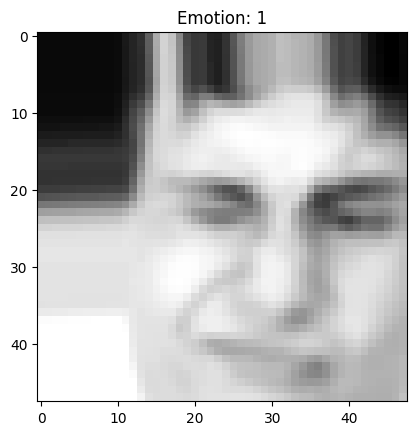

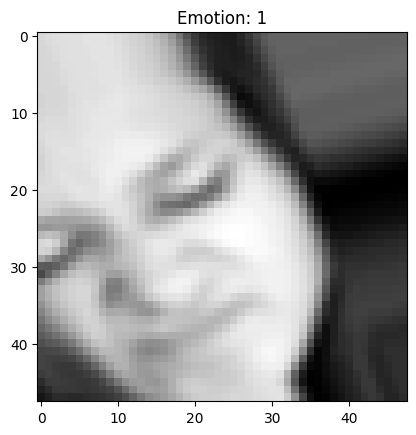

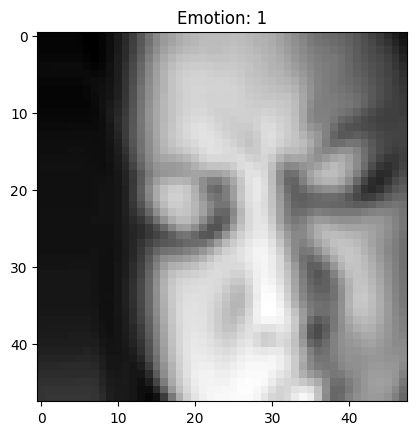

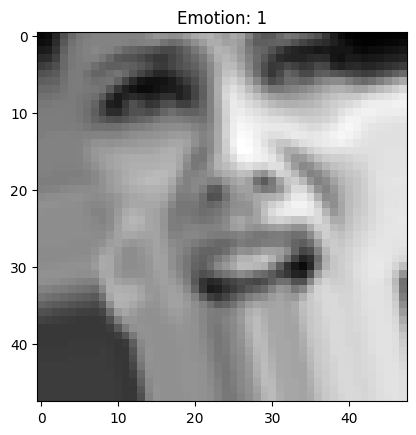

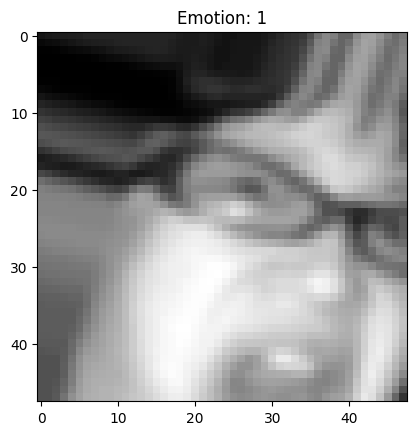

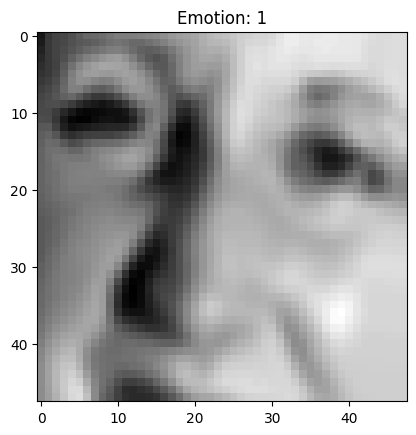

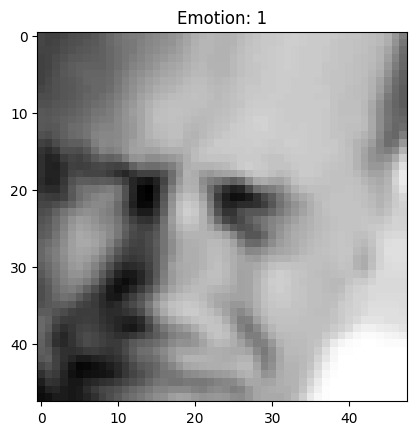

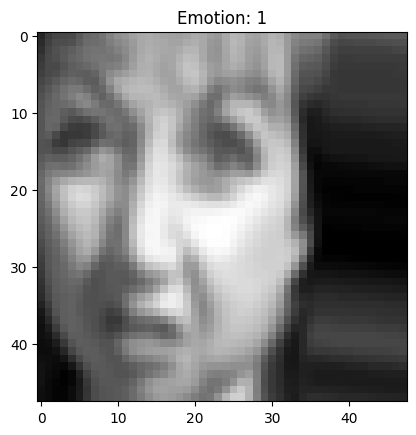

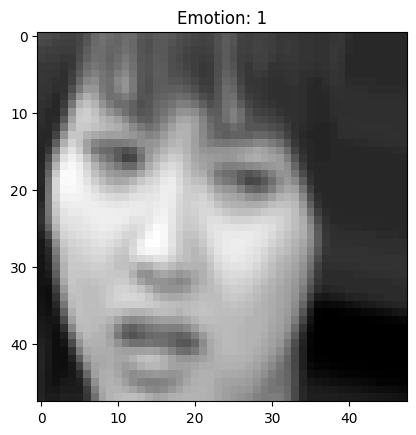

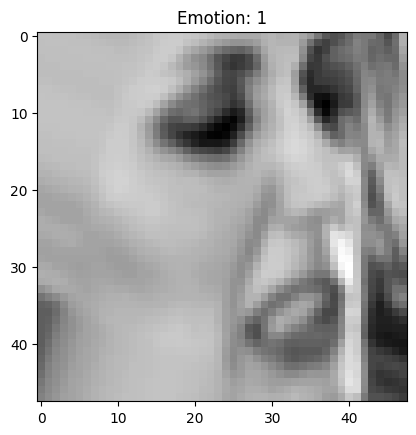

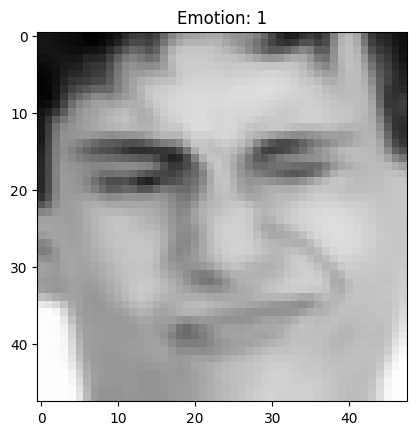

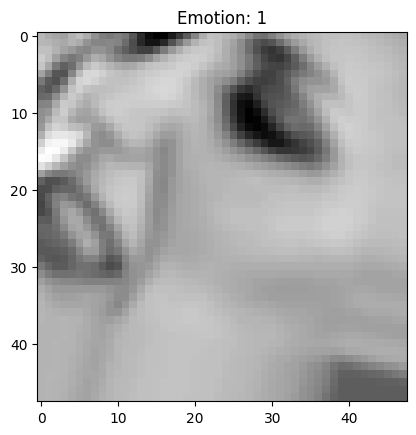

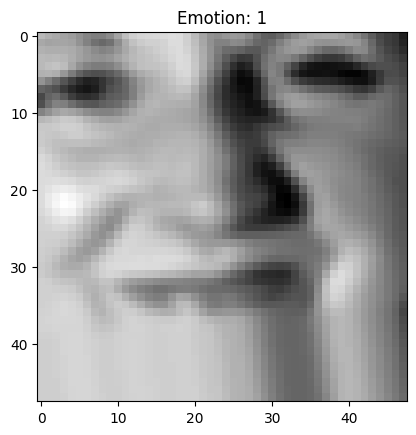

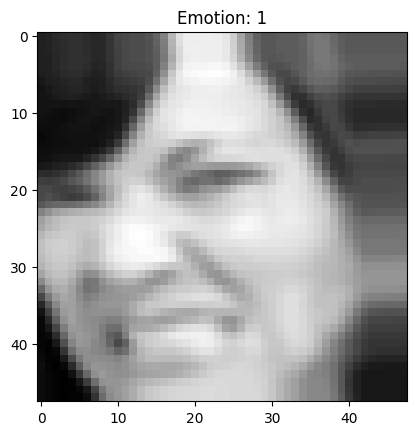

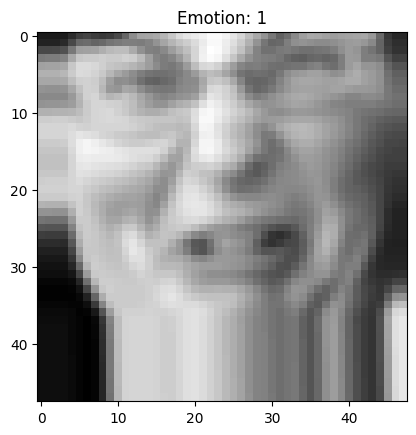

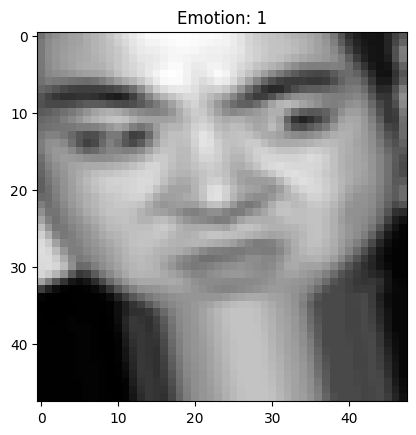

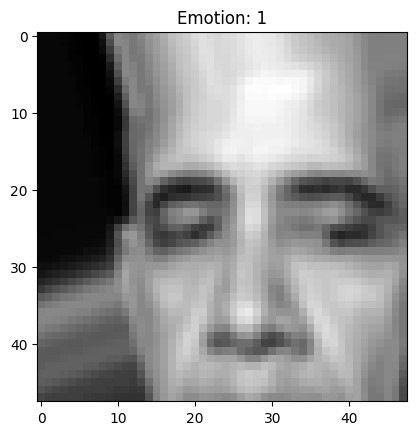

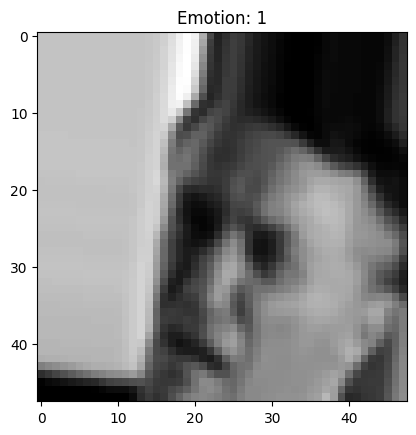

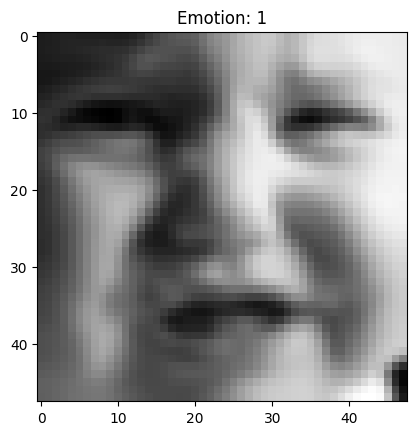

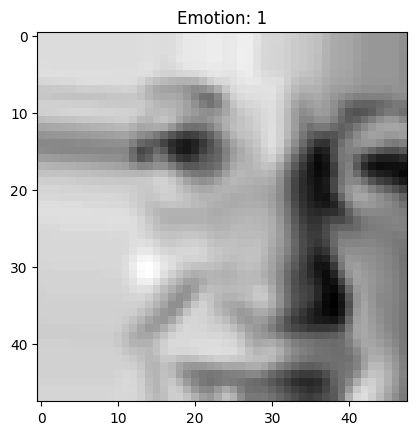

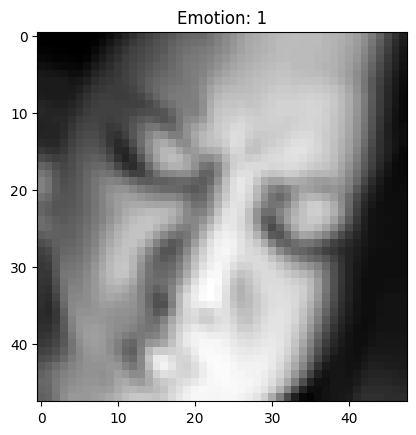

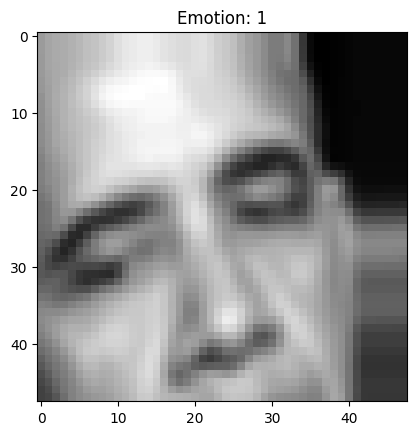

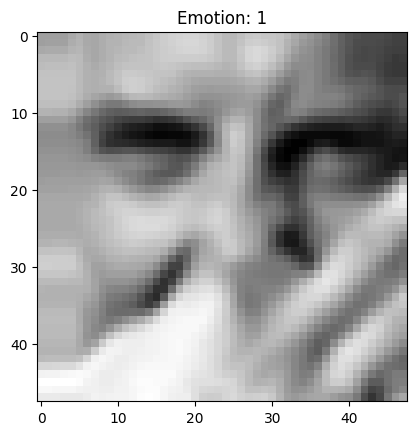

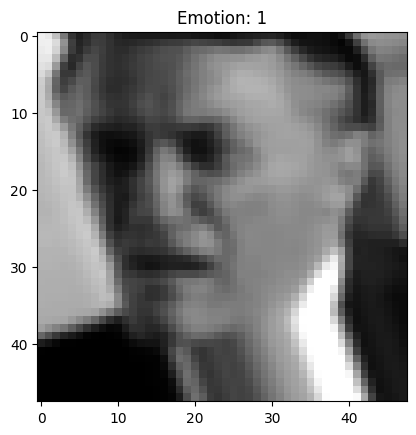

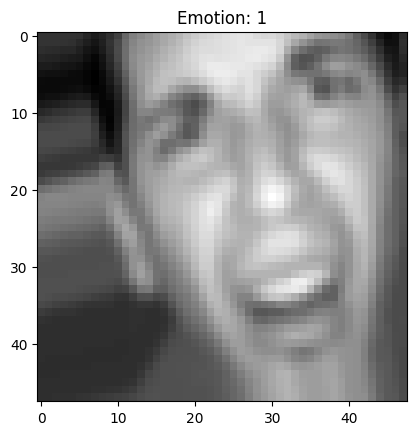

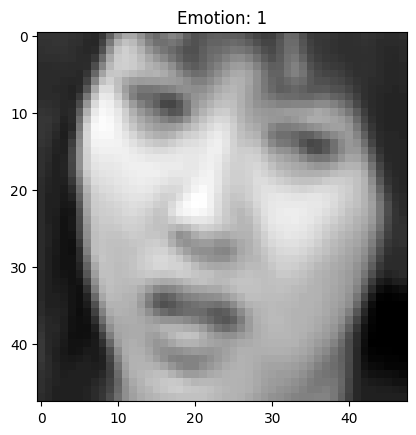

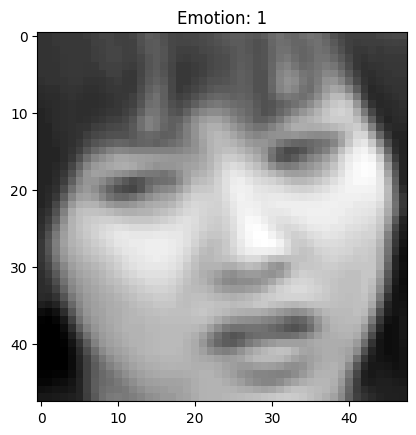

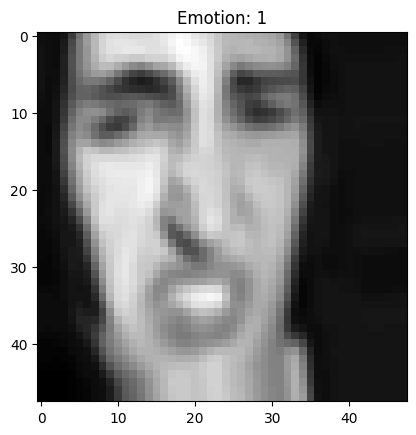

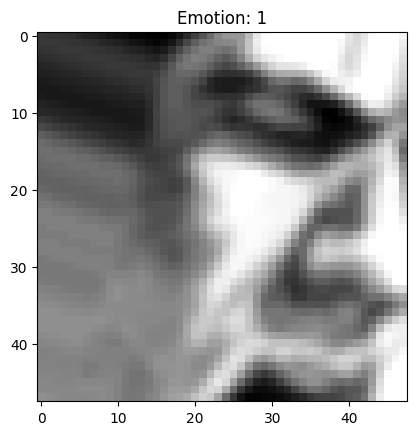

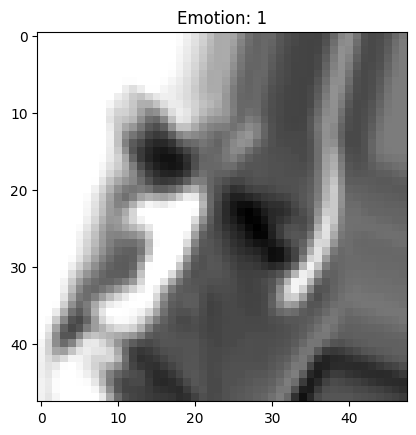

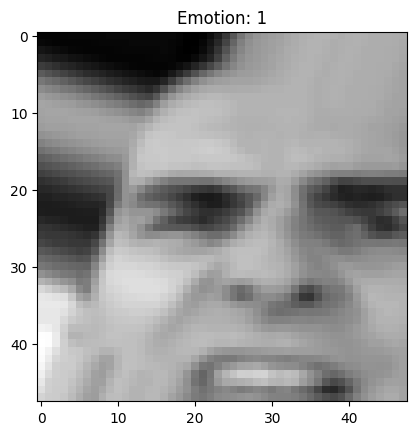

KeyboardInterrupt: 

<Figure size 640x480 with 0 Axes>

In [ ]:

for row in range(len(X_val1)):
    if y_val1[row] == 1:
        plt.figure()
        plt.imshow(X_val1[row], cmap='gray')
        plt.title(f"Emotion: {y_val1[row]}")
        plt.show()

In [ ]:
X_train = X_train1/255
y_train = y_train1
X_val = X_val1
y_val = y_val1

In [ ]:
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

# Input shape (48, 48, 1) for 48x48 grayscale images
input_shape = (48, 48, 1)

# One-hot encode the training and validation labels
y_train_one_hot = to_categorical(y_train, num_classes=7)
y_val_one_hot = to_categorical(y_val, num_classes=7)

# Initialize the model
model = Sequential()

# First Block: 2 Conv layers + MaxPooling
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=input_shape))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Second Block: 2 Conv layers + MaxPooling
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Third Block: 2 Conv layers + MaxPooling
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

# Fourth Block: 2 Conv layers + MaxPooling
model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

# Fully Connected Layers
model.add(Flatten())  # Flatten the 3D output to 1D
model.add(Dense(512, activation='relu'))  # First Dense Layer
model.add(BatchNormalization())
model.add(Dropout(0.5))  # Regularization

model.add(Dense(128, activation='relu'))  # Second Dense Layer
model.add(BatchNormalization())
model.add(Dropout(0.5))

# Output layer: 7 classes (softmax activation for multiclass classification)
model.add(Dense(7, activation='softmax'))

# Model Summary
model.summary()

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model without data augmentation
history = model.fit(X_train, y_train_one_hot,
                    epochs=50,  # Adjust the number of epochs as needed
                    validation_data=(X_val, y_val_one_hot),
                    batch_size=32)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 64)        640       
                                                                 
 batch_normalization (Batch  (None, 48, 48, 64)        256       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        36928     
                                                                 
 batch_normalization_1 (Bat  (None, 48, 48, 64)        256       
 chNormalization)                                                
                                                                 
 max_pooling2d (MaxPooling2  (None, 24, 24, 64)        0         
 D)                                                              
                                                        

In [ ]:
model.save_weights('/content/my_facial_expression_model_weights.h5')

In [ ]:
import tensorflow as tf

# Check if GPU is detected
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


In [ ]:
# Reading Images from data set validate

df = pd.read_csv(r"C:\Users\gsanj\OneDrive\Desktop\Jupyter\FACIAL EMOTIONS\test_dataset\test_dataset.csv")
def pixels_to_image(pixel_str):
    # Assuming each image is 48x48 pixels
    pixels = np.array([int(p) for p in pixel_str.split()], dtype='uint8')
    # print(len(pixels))
    img = pixels.reshape(48, 48)  # Adjust if image dimensions are different
    return img

# Add a column with images
df['test_image'] = df['pixels'].apply(pixels_to_image)

# Display the first few rows with images and emotion
# for idx, row in df.iterrows():
#     plt.figure()
#     plt.imshow(row['image'], cmap='gray')
#     plt.title(f"Emotion: {row['emotion']}")
#     plt.show()
len(df['test_image'])

In [ ]:
# Reading Images from data set validate

df = pd.read_csv(r"/content/test_dataset.csv")
def pixels_to_image(pixel_str):
    # Assuming each image is 48x48 pixels
    pixels = np.array([int(p) for p in pixel_str.split()], dtype='uint8')
    # print(len(pixels))
    img = pixels.reshape(48, 48)  # Adjust if image dimensions are different
    return img

# Add a column with images
df['test_image'] = df['pixels'].apply(pixels_to_image)

# Display the first few rows with images and emotion
# for idx, row in df.iterrows():
#     plt.figure()
#     plt.imshow(row['image'], cmap='gray')
#     plt.title(f"Emotion: {row['emotion']}")
#     plt.show()
len(df['test_image'])

2500

In [ ]:
X_test = df['test_image']
# Reshape the flattened images into 48x48x1 format

X_test_flattened = np.array(X_test.tolist())
num_images = X_test_flattened.shape[0]
X_test = X_test_flattened.reshape((num_images, 48, 48, 1))

X_test.shape

# Normalize pixel values (if necessary)
X_test = X_test.astype('float32') / 255.0

In [ ]:
# Predict the classes for X_test
y_pred = model.predict(X_test)

# Convert predicted probabilities to class labels
y_pred_classes = np.argmax(y_pred, axis=1)

# Save the predictions to a CSV file in the requested format (comma-separated)
np.savetxt('predicted_labels.csv', y_pred_classes, delimiter=',', fmt='%d')

print("Predictions saved to 'predicted_labels.csv' in comma-separated format")

79/79 [==============================] - 3s 40ms/step
Predictions saved to 'predicted_labels.csv' in comma-separated format


In [ ]:
image_ids = df['id']
y_pred_classes = np.argmax(y_pred, axis=1)

# Create a DataFrame to store the predictions with the corresponding IDs
df_predictions = pd.DataFrame({
    'ImageID': image_ids,
    'PredictedLabel': y_pred_classes
})

# Save the DataFrame to a CSV file
df_predictions.to_csv('predicted_labels_with_ids.csv', index=False)

print("Predictions saved to 'predicted_labels_with_ids.csv' with ImageID and PredictedLabel")

Predictions saved to 'predicted_labels_with_ids.csv' with ImageID and PredictedLabel
